# Load model, parameters, performance metrics

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
from models.vqvae import VQVAE
import os
import shutil
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time

In [3]:
# Constants for argument values
BATCH_SIZE = 32
N_UPDATES = 5000
N_HIDDENS = 128  # Updated to 128
N_RESIDUAL_HIDDENS = 64  # Updated to 64
N_RESIDUAL_LAYERS = 3  # Updated to 3
EMBEDDING_DIM = 128  # Updated to 128
N_EMBEDDINGS = 512
BETA = 0.25
LEARNING_RATE = 3e-4
LOG_INTERVAL = 50

In [4]:
class GravitationalHackathonDataset(Dataset):
    """
    Loads gravitational hackathon dataset
    """

    def __init__(self, file_path, train=True):
        if file_path.split('.')[-1]=='npz':
            data = np.load(file_path, allow_pickle=True)['data']
            data = np.random.permutation(data)
        else:
            data = np.load(file_path)
        stds = np.std(data, axis=-1)[:, :, np.newaxis]
        data = data/stds
        if train:
            np.save("backgroundtest.npy", data[-20000:])
            data = data[:-20000].reshape(-1, 1, data.shape[-2], data.shape[-1])
        self.data = data

    def __getitem__(self, index):
        img = self.data[index]
        label = 0
        return img, label

    def __len__(self):
        return len(self.data)

In [5]:
def load_hackathon(filepath):
    
    train = GravitationalHackathonDataset(filepath)
    print(train.data.shape)

    return train

In [6]:
def save_model_and_results(model, results, timestamp):
    SAVE_MODEL_PATH = os.getcwd() + '/results'

    results_to_save = {
        'model': model.state_dict(),
        'results': results,
    }
    torch.save(results_to_save,
               SAVE_MODEL_PATH + '/vqvae_data_' + timestamp + '.pth')

In [7]:
data_folder_path = os.getcwd()
data_file_path = data_folder_path + '/data/background.npz'
training_data = load_hackathon(filepath=data_file_path)
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
x_train_var = np.var(training_data.data)
print(x_train_var)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


(80000, 1, 2, 200)
1.0004745609705747


Model Definations

In [8]:
class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

In [9]:
class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, channel, height, width)

        quantization pipeline:

            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)

        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices


In [10]:
class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta 
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = (2, 4)
        stride = (1, 1)
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, 
                      kernel_size=kernel,
                      stride=stride, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, 
                      kernel_size=kernel,
                      stride=stride, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, 
                      kernel_size=(kernel[0] - 1, kernel[1] - 1),
                      stride=stride, 
                      padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)

        )

    def forward(self, x):
        return self.conv_stack(x)


In [11]:
class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi 
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = (2, 4)
        stride = (1, 1)

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, 
                kernel_size=(kernel[0] - 1, kernel[1]-1), 
                stride=stride, 
                padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               
                               kernel_size=kernel, 
                               stride=stride, 
                               padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 1, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)


In [12]:

class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(1, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)
        # Decoder(128, 128, 3, 64)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):
        z_e = self.encoder(x.float())

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(
            z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity


In [13]:
model = VQVAE(N_HIDDENS, N_RESIDUAL_HIDDENS,
              N_RESIDUAL_LAYERS, N_EMBEDDINGS, EMBEDDING_DIM, BETA).to(device)

In [14]:
"""
Set up optimizer and training loop
"""
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)

model.train()

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(1, 64, kernel_size=(2, 4), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0): ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
          (1): ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(6

In [15]:
results = {
    'n_updates': 0,
    'recon_errors': [],
    'loss_vals': [],
    'perplexities': [],
}

def train():
    for i in range(N_UPDATES):
        (x, _) = next(iter(training_loader))
        x = x.to(device)
        optimizer.zero_grad()

        embedding_loss, x_hat, perplexity = model(x)
        recon_loss = torch.mean((x_hat - x)**2) / x_train_var
        loss = recon_loss + embedding_loss

        loss.backward()
        optimizer.step()

        results["recon_errors"].append(recon_loss.cpu().detach().numpy())
        results["perplexities"].append(perplexity.cpu().detach().numpy())
        results["loss_vals"].append(loss.cpu().detach().numpy())
        results["n_updates"] = i

        if i % LOG_INTERVAL == 0:
            """
            save model and print values
            """
            timestamp = time.ctime().replace('  ', ' ').replace(' ', '_').replace(':', '_').lower()

            save_model_and_results(model, results, timestamp)

            print('Update #', i, 'Recon Error:',
                  np.mean(results["recon_errors"][-LOG_INTERVAL:]),
                  'Loss', np.mean(results["loss_vals"][-LOG_INTERVAL:]),
                  'Perplexity:', np.mean(results["perplexities"][-LOG_INTERVAL:]))

In [21]:
train()

Update # 0 Recon Error: 1.0038436225350207 Loss 1.0084917994882172 Perplexity: 2.67549


KeyboardInterrupt: 

In [20]:
# Assume `model` is the trained VQVAE instance
# Set the model to evaluation mode
model.eval()

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(1, 64, kernel_size=(2, 4), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-2): 3 x ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (pre_quantization_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (vector_quantization): VectorQuantizer(
    (embedding): Embedding(512, 128)
  )
  (decoder): Decoder(
    (inverse_conv_stack): Sequential(
      (0): C

In [ ]:
model.load_state_dict(torch.load("results/vqvae_data_sun_jan_12_08_26_21_2025.pth")['model'])

In [16]:
# bbh = np.load('bbh_for_challenge.npy')
# backgroundtest = np.load('backgroundtest.npy')

# bbhpath = data_folder_path + '/bbh_for_challenge.npy'
# bbh = load_hackathon(filepath=data_file_path, train=False)
# bbhloader = DataLoader(bbh, batch_size=BATCH_SIZE, pin_memory=True)
# x_train_var = np.var(bbhloader.data)
# print(x_train_var)

@torch.no_grad()
def process_batches(data_file_path, batch_size):
    # Create a DataLoader for batching
    data = load_hackathon(filepath=data_file_path)
    data_loader = DataLoader(data, batch_size=BATCH_SIZE, pin_memory=True)

    outputs = []

    for batch in data_loader:        
        # Run the operations
        batch_data = batch[0]
        z_e = model.encoder(batch_data.float())  # Continuous latent representation
        z_e = model.pre_quantization_conv(z_e)  # Pre-quantized vector
        decoded_output = model.decoder(z_e).reshape(batch_data.shape[0], 2, 200)  # Decode and reshape
        
        outputs.append(decoded_output)

    # Concatenate all outputs back to a single tensor
    outputs = torch.cat(outputs, dim=0)
    return outputs.to('cpu').numpy().reshape(-1, 2, 200)

def predict(X, batch_size=8):
    return np.mean((process_batches(data_file_path=X, batch_size=batch_size) - np.load(X)) ** 2, axis=(1,2))


# Train Graphs

In [17]:
model2 = VQVAE(N_HIDDENS, N_RESIDUAL_HIDDENS,
                N_RESIDUAL_LAYERS, N_EMBEDDINGS, EMBEDDING_DIM, BETA).to(device)
data = torch.load("results/vqvae_data_sun_jan_12_10_49_12_2025.pth", map_location=torch.device('cpu'))
print(data['results'].keys())

dict_keys(['n_updates', 'recon_errors', 'loss_vals', 'perplexities'])


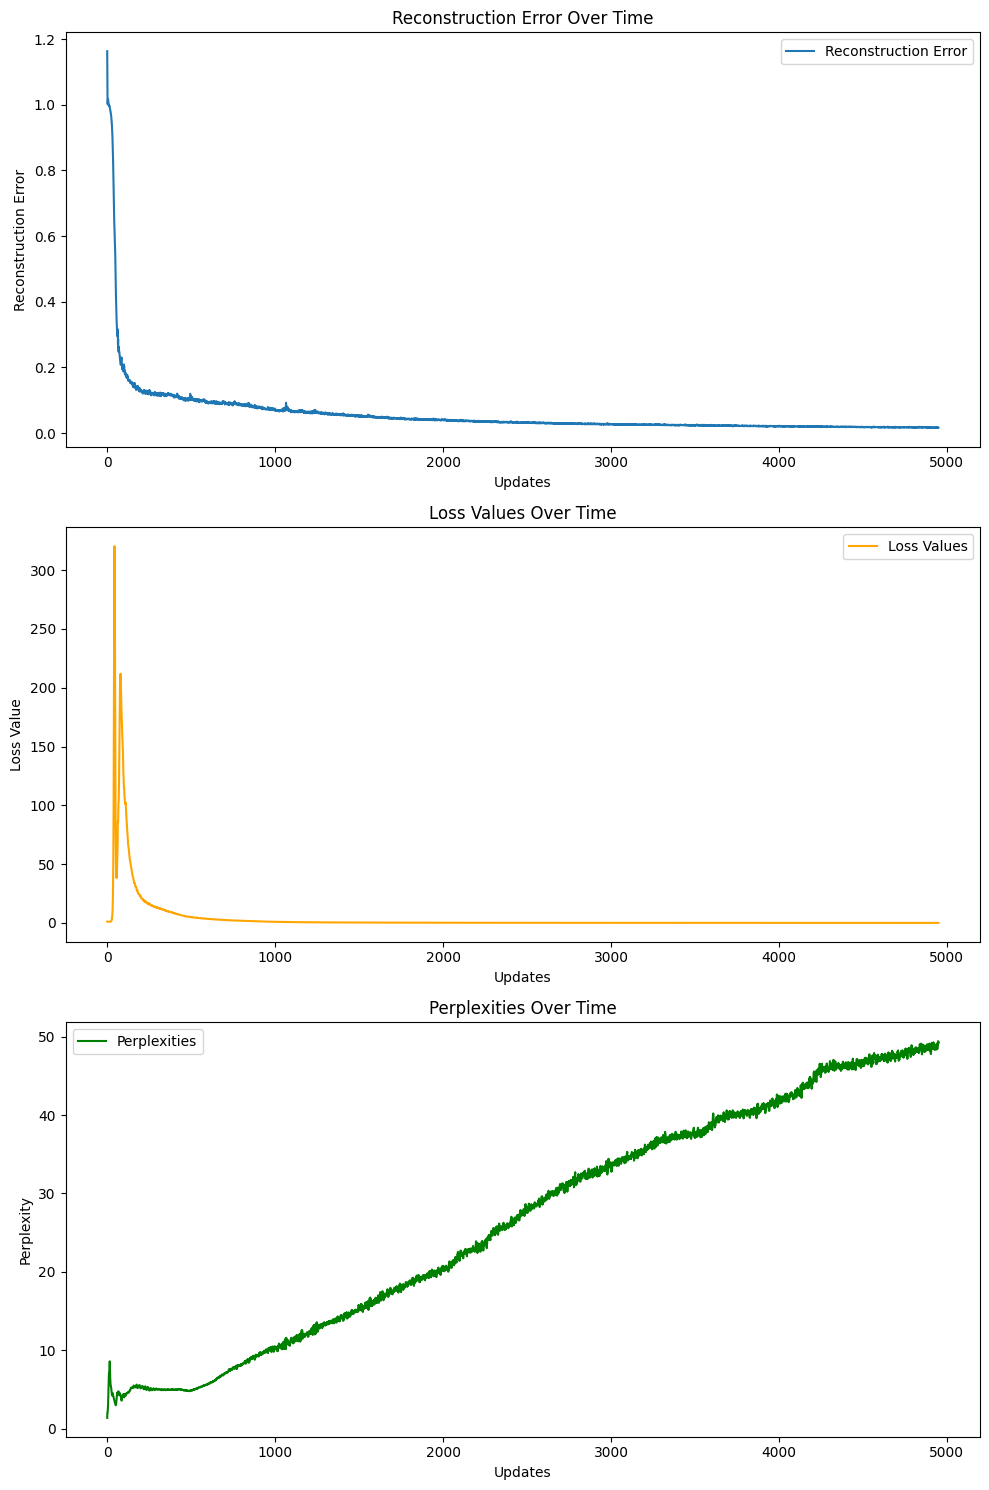

In [18]:
import matplotlib.pyplot as plt

# Extract data
recon_errors = data['results']['recon_errors']
loss_vals = data['results']['loss_vals']
perplexities = data['results']['perplexities']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot recon_errors
axs[0].plot(recon_errors, label='Reconstruction Error')
axs[0].set_title('Reconstruction Error Over Time')
axs[0].set_xlabel('Updates')
axs[0].set_ylabel('Reconstruction Error')
axs[0].legend()

# Plot loss_vals
axs[1].plot(loss_vals, label='Loss Values', color='orange')
axs[1].set_title('Loss Values Over Time')
axs[1].set_xlabel('Updates')
axs[1].set_ylabel('Loss Value')
axs[1].legend()

# Plot perplexities
axs[2].plot(perplexities, label='Perplexities', color='green')
axs[2].set_title('Perplexities Over Time')
axs[2].set_xlabel('Updates')
axs[2].set_ylabel('Perplexity')
axs[2].legend()

# Show the plots
plt.tight_layout()
plt.show()